In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd #데이터프레임(엑셀 테이블과 같은 데이터)를 다루는 라이브러리
import numpy as np #행렬 연산을 돕는 라이브러리

books=pd.read_csv('/content/drive/MyDrive/books.csv') #read_csv 함수는 csv파일을 구글 드라이브로부터 불러옵니다
ratings=pd.read_csv('/content/drive/MyDrive/ratings.csv')
books=books.replace(np.nan, 'nan') #데이터프레임 내 NAN이라는 Null값을 문자열로 대치합니다
#파이썬에는 숫자형 자료와 문자열 자료가 있으며, 둘이 인식되는게 다릅니다

In [ ]:
!pip install lightfm #lightFM 라이브러리 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=879183 sha256=9ab16b25fc7f5b4a1e1433cf6640f746c4b7c6725a3febb175643d251d7973bd
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
import nltk #자연어 처리 라이브러리
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd

from scipy.io import mmwrite
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
#from sklearn.feature_extraction.text import CountVectorizer


#vectorizer = CountVectorizer(stop_words=None, ngram_range=(2,2))

# Data Load
# ratings_source: build_interactions 재료, list of tuples
# --> [(user1, item1), (user2, item5), ... ]
# item_features_source: build_item_features 재료
# --> [(item1, [feature, feature, ...]), (item2, [feature, feature, ...])]

stemmer = PorterStemmer() #어간 추출 라이브러리

ratings_source = [(ratings['user_id'][i], ratings['book_id'][i]) for i in range(ratings.shape[0])] #User 행렬

item_meta = books[['book_id', 'authors', 'average_rating', 'original_title']] #item 행렬

for i in range(item_meta.shape[0]): #item_meta 전체 데이터프레임에 대한 반복문

  token=word_tokenize(item_meta['original_title'][i]) #단어 띄어쓰기 분리
  token=[stemmer.stem(word) for word in token] #어간 추출
  item_meta['original_title'][i]=' '.join(token) #문자열 형태로 다시 합쳐서 Return

#유사도를 계산하기 위하여 item feature source들을 아래 튜플 형태로 반환합니다. [책 아이디, 저자, 평균 평점, 제목]
item_features_source = [(item_meta['book_id'][i],
                        [item_meta['authors'][i],
                         item_meta['average_rating'][i],item_meta['original_title'][i]]) for i in range(item_meta.shape[0])]

<ipython-input-73-5847b1d8632d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_meta['original_title'][i]=' '.join(token) #문자열 형태로 다시 합쳐서 Return


In [ ]:
item_meta['original_title'][0]

'thehungergame'

#LightFM

LightFM은 상위권 수준의 성능을 내고 있는 추천시스템 인공신경망 중의 하나입니다. 원리 자체는 User가 특정 아이템에 평점을 매긴 User-Item Dataframe을 수리적으로 행렬 분해를 거쳐 나머지 평점들의 값들을 예측하는데 기반합니다.

이를 통하여 평점을 매기지 않은 아이템들에 대하여 유저에게 비교적 끌릴 만한 아이템들을 추천해줍니다.

Content based 추천 / Collaborative Filtering이라고 user-item matrix만 가지고 추천해주는 두 종류가 있는데, 본 모델은 두 종류를 모두 합쳤습니다. 즉, 유저와 해당 아이템 사이의 관계와 더불어 아이템 끼리의 관계도 볼 수 있으며, 심지어 유저끼리의 유사도도 사용하여 예측할 수 있습니다.

본 모델의 이름처럼 굉장히 light하기 때문에, 실시간으로 평점이 매겨지면 다시 training 작업을 거쳐 더 정확한 추천을 가능케합니다.

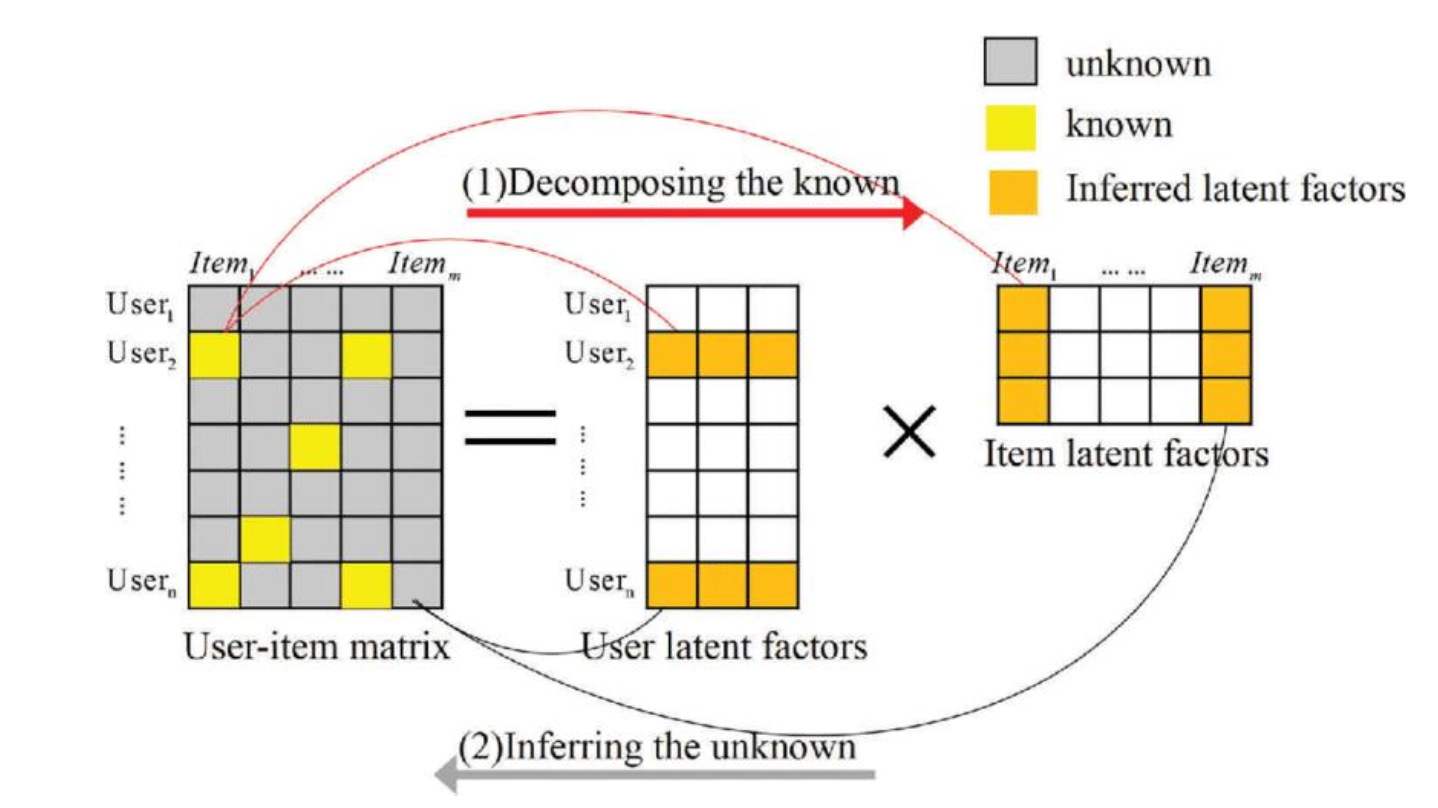

다음과 같은 행렬로 User-Item Matrix를 분해합니다. 이러한 과정을 SVD(특잇값 분해)라고 합니다.

A=USVᵀ

여기서 U는 User latent Matrix를, S는 Diagonal Matrix, Vᵀ 는 Item latent Matrix가 Transpose(행과 열이 전치된 것)된 행렬을 의미합니다.

즉, User-item 행렬은 빈 곳이 굉장히 많습니다(유저가 모든 책과 상품을 다 읽고 평가할 수는 없으니까요). 하지만 상기된 특잇값 분해를 통하여 특정한 잠재 변수가 user와 item 사이에 있다는 것을 전제로 해당 행렬 분해를 진행하게 됩니다.
*해당 내용은 선형대수이긴 하나, 잠재 변수가 정말 어떤 '의미'인지 선형적으로 증명하기가 어렵습니다.

어쨌든, 우리가 알고 있는 행렬을 분해하고 다시 추론하는 과정에서 저 S 행렬 속에 들어가는 값들을 맞추는 것이 인공신경망 학습의 목적입니다(가운데 행렬 값을 고정시키면, User 행렬과 item 행렬이 deterministic한 값을 가지게 될 것입니다).



In [ ]:
from lightfm.data import Dataset

dataset = Dataset() #데이터셋 클래스 호출
dataset.fit(users=ratings['user_id'].unique(), #user_id의 고윳값만
            items=ratings['book_id'].unique(), #book_id의 고윳값만
            item_features=item_meta[item_meta.columns[1:]].values.flatten() #item_meta 값들의 칼럼(author, average_rating, original_title)에 대하여 1차원으로 펴줍니다(flatten)
            )

In [ ]:
from lightfm.cross_validation import random_train_test_split

interactions, weights = dataset.build_interactions(ratings_source) #user - item 간 latent variable을 계산하여 교차행렬과 가중치를 뽑아냅니다(행렬 분해)
item_features = dataset.build_item_features(item_features_source) #아이템 feature 추출

# Save
#mmwrite('data/interactions.mtx', interactions)
#mmwrite('data/item_features.mtx', item_features)
#mmwrite('data/weights.mtx', weights)

# Split Train, Test data
train, test = random_train_test_split(interactions, test_percentage=0.1) #9:1로 데이터셋을 나눕니다
train, test = train.tocsr().tocoo(), test.tocsr().tocoo() #tocoo는 scipy라는 numpy를 포괄하는 과학 연산 라이브러리의 행렬로 바꿔줌
train_weights = train.multiply(weights).tocoo()

In [91]:
from hyperopt import fmin, hp, tpe, Trials #hyperparameter를 tuning해주는 라이브러리

# Define Search Space
trials = Trials()
space = [hp.choice('no_components', range(10, 110, 20)), #no_components:latent variable - dimension
         hp.uniform('learning_rate', 0.01, 0.05)] #learning_rate: 인공지능 모델이 데이터 학습율

In [90]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k,auc_score #가장 정확한 k개의 비슷한 걸 뽑는다는 의미


# Define Objective Function
def objective(params):
    no_components, learning_rate = params

    model = LightFM(no_components=no_components,
                    learning_schedule='adagrad', #adagrad: The optimizer for artificial network_it optimizes the model
                    loss='warp', #loss function calculate the difference between the prediction and real target(answer)
                    learning_rate=learning_rate,
                    random_state=0)

    model.fit(interactions=train, #fit method를 통하여 해당 인공신경망을 학습시킵니다.
              item_features=item_features,
              sample_weight=train_weights,
              epochs=3,
              verbose=False)

    test_precision = precision_at_k(model, test, k=10, item_features=item_features).mean() #precision average
    print("no_comp: {}, lrn_rate: {:.5f}, precision: {:.5f}".format(
      no_components, learning_rate, test_precision))
    test_auc = auc_score(model, test, item_features=item_features).mean() #auc_score 계산(분류 모델의 성능 지표(area under the curve)로 높을 수록 좋음)
    output = -test_precision

    if np.abs(output+1) < 0.01 or output < -1.0:
        output = 0.0

    return output

In [ ]:
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

no_comp: 90, lrn_rate: 0.04854, precision: 0.06141
no_comp: 70, lrn_rate: 0.03903, precision: 0.05968
no_comp: 70, lrn_rate: 0.03055, precision: 0.05787
no_comp: 10, lrn_rate: 0.02431, precision: 0.05008
no_comp: 70, lrn_rate: 0.04993, precision: 0.06153
no_comp: 10, lrn_rate: 0.02071, precision: 0.04939
no_comp: 90, lrn_rate: 0.03156, precision: 0.05894
no_comp: 70, lrn_rate: 0.04861, precision: 0.06110
no_comp: 50, lrn_rate: 0.03903, precision: 0.05828
no_comp: 70, lrn_rate: 0.01216, precision: 0.05045
100%|██████████| 10/10 [1:05:36<00:00, 393.66s/trial, best loss: -0.06152722239494324]


In [ ]:
model = LightFM(no_components=70, #latent variable - dimension : 70
                    learning_schedule='adagrad',
                    loss='warp',
                    learning_rate=0.04993,
                    random_state=0)

model.fit(interactions=train,
              item_features=item_features,
              sample_weight=train_weights,
              epochs=10,
              verbose=True)

item_biases, item_embeddings = model.get_item_representations(features=item_features)

def make_best_items_report(item_embeddings, book_id, num_search_items=10):
    item_id = book_id - 1

    # Cosine similarity: 코사인 유사도를 통하여 두 아이템 간 유사도를 계산합니다.
    # 코사인 함수 특성상 두 벡터의 차이가 작을 수록 1에 수렴하며, 반대의 경우 음수가 됩니다.
    scores = item_embeddings.dot(item_embeddings[item_id])  # (10000, )
    item_norms = np.linalg.norm(item_embeddings, axis=1)    # (10000, )
    item_norms[item_norms == 0] = 1e-10
    scores /= item_norms

    # best: score가 제일 높은 item의 id를 num_search_items 개 만큼 가져온다.
    best = np.argpartition(scores, -num_search_items)[-num_search_items:] #argpartition은 y=f(x)라고 인공신경망을 가정했을 때, partition되는 값을 만족하는 x를 가져오는 것을 의미
    similar_item_id_and_scores = sorted(zip(best, scores[best] / item_norms[item_id]),
                                        key=lambda x: -x[1]) #유사도가 높은 순대로 아이템들을 정렬

    # Report를 작성할 pandas dataframe
    best_items = pd.DataFrame(columns=['book_id', 'title', 'author', 'score'])

    for similar_item_id, score in similar_item_id_and_scores:
        book_id = similar_item_id + 1
        title = item_meta[item_meta['book_id'] == book_id].values[0][3] #title이 세번째 칼럼에 있어서 [0][3]
        author = item_meta[item_meta['book_id'] == book_id].values[0][1] #author가 첫번째 칼럼에 있어서 [0][1]

        row = pd.Series([book_id, title, author, score], index=best_items.columns)
        best_items = best_items.append(row, ignore_index=True)

    return best_items


# book_id 2: Harry Potter and the Philosopher's Stone by J.K. Rowling, Mary GrandPré
# book_id 9: Angels & Demons by Dan Brown
report01 = make_best_items_report(item_embeddings, 2, 10)
report02 = make_best_items_report(item_embeddings, 9, 10)

Epoch: 100%|██████████| 10/10 [13:44<00:00, 82.47s/it]
<ipython-input-87-0417da83e50c>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_items = best_items.append(row, ignore_index=True)
<ipython-input-87-0417da83e50c>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_items = best_items.append(row, ignore_index=True)
<ipython-input-87-0417da83e50c>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_items = best_items.append(row, ignore_index=True)
<ipython-input-87-0417da83e50c>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_items = best_items.append(row, ignore_index=True)
<ipython-input-87-0417da83e50c>:38: Futur

In [88]:
report01

,book_id,title,author,score
0,2,harri potter and the philosoph 's stone,"J.K. Rowling, Mary GrandPré",1.000000
1,7221,eeni meeni,M.J. Arlidge,0.725499
2,6717,"the morganvil vampir , volum 3",Rachel Caine,0.709443
3,2230,the black cauldron,Lloyd Alexander,0.679417
4,2426,300,"Frank Miller, Lynn Varley",0.679155
5,2083,the darkest night,Gena Showalter,0.678502
6,1386,black and blue,Anna Quindlen,0.674881
7,1577,be mortal : medicin and what matter in the end,Atul Gawande,0.671188
8,105,allegi,Veronica Roth,0.669516
9,1376,the ugli truth,Jeff Kinney,0.664444


In [89]:
report02

,book_id,title,author,score
0,9,angel & demon,Dan Brown,1.000000
1,3687,lord of misrul,Rachel Caine,0.899779
2,666,anansi boy,Neil Gaiman,0.848301
3,971,nan,"Marcus Pfister, J. Alison James",0.836907
4,552,the rescu,Nicholas Sparks,0.823112
5,208,the immort life of henrietta lack,Rebecca Skloot,0.819470
6,724,from dead to wors,Charlaine Harris,0.818295
7,176,it,Stephen King,0.810142
8,504,nan,Francine Rivers,0.808088
9,503,2001 : a space odyssey,Arthur C. Clarke,0.804918
